## learning-AI : deep learning application (61357002)
### assignment : abalone regression (DL)

**전복 데이터를 Dense layer structure creation하여 regression (ANN, DNN)**

<br>

- **임규연 (lky473736)**
- 2024.09.11.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/1/abalone
- **data abstract** : Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem. From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

------



## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 abalone을 regression한다. 목차는 아래와 같다.

- **1. 데이터 분석, 시각화 및 전처리**
- **2. SGDRegressor 통한 ML에서의 확률적 경사 하강법 적용**
- **3. ANN (fully connected)**
- **4. DNN**


In [6]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

------

### 1. 데이터 분석, 시각화 및 전처리
- 데이터 로드 및 필요한 정보, 기초통계량을 get한다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- cell 순서는 아래와 같다.
    - (1) 데이터 읽기 및 head 파악
    - (2) 데이터 info (결측치 파악), 데이터 크기
    - (3) 데이터 기초통계량 확인 
    - (4) heatmap
    - (5) feature, target data split
    - (6) train set, test set, validation set split 
    - (7) scaling (z-score normalization)

In [7]:
# (1) 데이터 읽기 및 head 파악

df = pd.read_csv('../../data/abalone.csv')
df.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [8]:
# (2) 데이터 info (결측치 파악), 데이터 크기

print('dataframe size : ', df.shape)
print ('dataframe columns : ', df.columns)
df.info()

dataframe size :  (4177, 10)
dataframe columns :  Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
       'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4177 non-null   int64  
 1   Sex             4177 non-null   object 
 2   Length          4177 non-null   float64
 3   Diameter        4177 non-null   float64
 4   Height          4177 non-null   float64
 5   Whole_weight    4177 non-null   float64
 6   Shucked_weight  4177 non-null   float64
 7   Viscera_weight  4177 non-null   float64
 8   Shell_weight    4177 non-null   float64
 9   Rings           4177 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 326.5+ KB


In [9]:
# (3) 데이터 기초통계량 확인

df.describe()

,id,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,2088.000000,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,1205.940366,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,1044.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,2088.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,3132.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,4176.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [10]:
# id열 제거 및 Sex 열을 string -> 수치 변환하기 위해 labelencoder로 변경

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df = df.drop('id', axis=1) # id열 제거
df['Sex'] = label_encoder.fit_transform(df['Sex']) # label encoding

print (df['Sex'].unique())

[2 0 1]



**regression의 target은 'Rings'가 될 것이다.** 

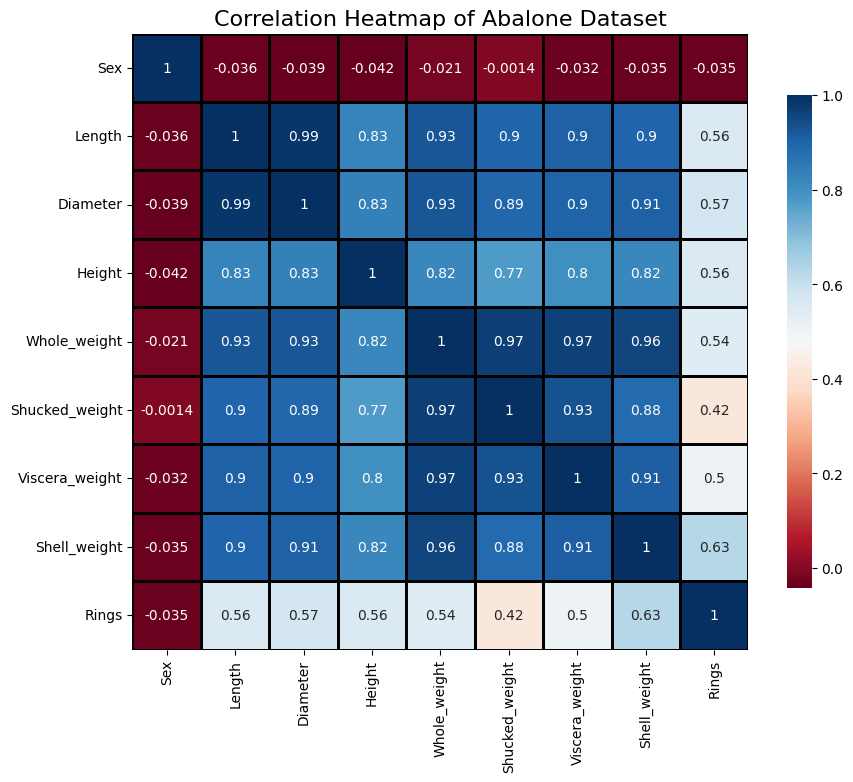

In [11]:
# (4) heatmap

correlation_matrix = df[df.columns].corr() 
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Abalone Dataset', fontsize=16)
plt.show()

In [12]:
# (5) target, feature split

abalone_input = df[[feature for feature in df.columns if feature != 'Rings']]
abalone_target = df['Rings']

print (abalone_input.shape, abalone_target.shape)

(4177, 8) (4177,)


In [13]:
# (6) train set, test set, validation set split

# X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(abalone_input, 
                                                   abalone_target,
                                                   test_size=0.1) 

# X_train, y_train, X_val, y_val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.1)

In [14]:
# (7) scaling

# normal data scaling
ss_transformer = StandardScaler()
ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)
X_val_scaled = ss_transformer.transform(X_val)

-------

### 2. SGDRegressor 통한 ML에서의 확률적 경사 하강법 적용
deep learning을 하기 전, deep learning의 weight 및 bias 조정법인 **SGD (Stochastic Gradient Descent)** 를 scikit-learn으로 구현해본다. parameter는 random search를 통하여 최적화할 것이며, 자세한 조정범위는 아래에 서술한다.
- loss function : squared_loss function
- max_iter : 3~50 (randint)

In [15]:
# random search를 통한 hyperparameter tuning
# ConvergenceWarning을 방지함

from sklearn.linear_model import SGDRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings

param = {
    'max_iter': randint(3, 50)
}

sr = SGDRegressor(loss='squared_error', max_iter=1000)
rs = RandomizedSearchCV(sr, param, n_iter=50, n_jobs=-1)

with warnings.catch_warnings() :
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    rs.fit(X_train_scaled, y_train)

print ("best params for rs :", rs.best_params_)
print ("best score for rs :", rs.best_score_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration re

best params for rs : {'max_iter': 46}
best score for rs : 0.50520941251393


ached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/l

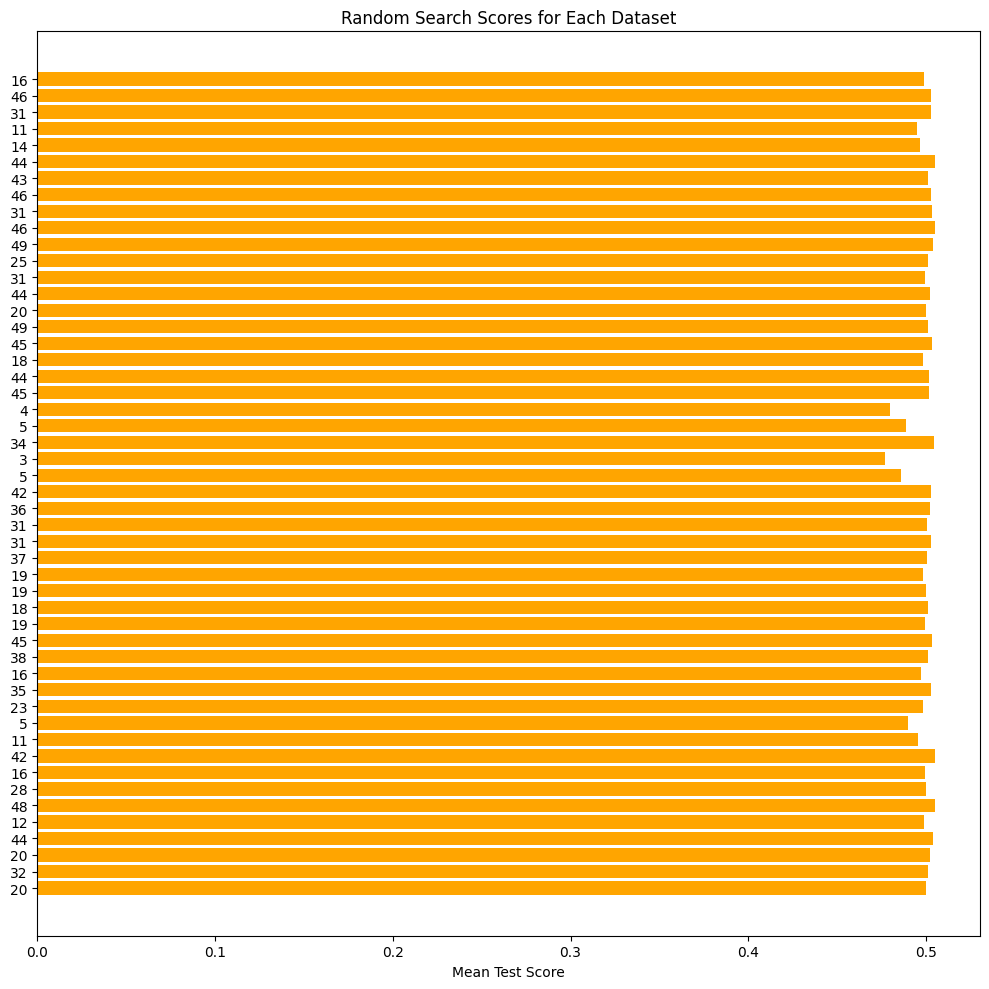

In [16]:
# 하이퍼파라미터 조합별 성능 시각화

results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

max_iter_values = [params[i]['max_iter'] for i in range(len(params))]

plt.figure(figsize=(10, 10))
plt.barh(range(len(mean_scores)), mean_scores, 
         tick_label=[f"{compo}" for compo in max_iter_values], color='orange')

plt.xlabel('Mean Test Score')
plt.title('Random Search Scores for Each Dataset')
plt.tight_layout()
plt.show()


In [17]:
# best score, best model, train score, test score

sr = rs.best_estimator_
print ("rs (normal dataset)")
print ("best score : ", rs.best_score_)
print ("best estimator (model) : ", sr)

sr_score = [sr.score(X_train_scaled, y_train), sr.score(X_test_scaled, y_test),
             sr.score(X_val_scaled, y_val)]
print (f"train score, test score, val score : {sr_score}")

rs (normal dataset)
best score :  0.50520941251393
best estimator (model) :  SGDRegressor(max_iter=46)
train score, test score, val score : [0.5190516664914303, 0.5115549997471855, 0.5200251601540185]


-------

### 3.  ANN (fully connected)
- hidden layer를 구성하지 않고, 입력층과 출력층만 존재하는 인공신경망을 struction할 것이다.
- 기존 train set에서 validation set을 하나 더 구성하였고, 추후 evaluation에 사용할 예정이다.
- 출력층의 activation은 사용하지 않는다. (regression problem)
- compile 시 loss function은 mse를 사용한다. 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

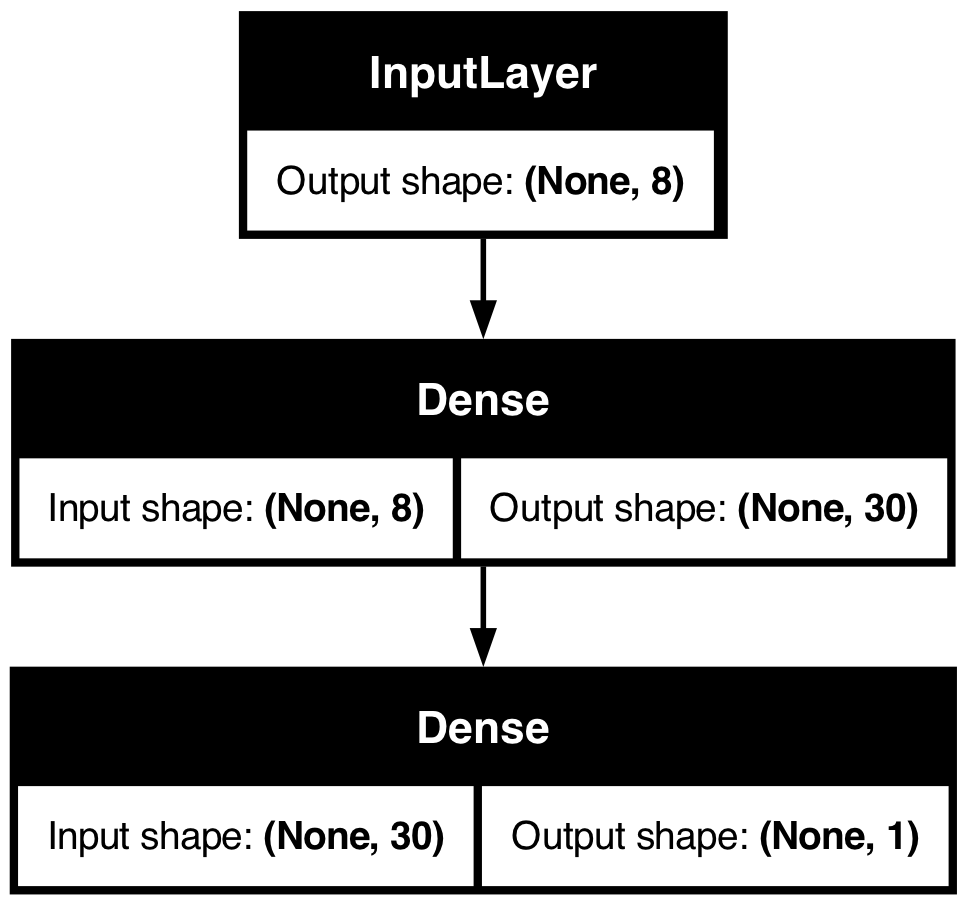

In [18]:
# modelling (functional API)

input_layer = keras.Input(shape=(len([feature for feature in df.columns if feature != 'Rings']), ))
dense_1 = keras.layers.Dense(30)(input_layer)
output_layer = keras.layers.Dense(1)(dense_1) 
model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [19]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='mse', metrics=['mse'])

In [20]:
# fit 

history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), batch_size=10, 
                    # callbacks=early_stopping_cb, 
                    verbose=0)

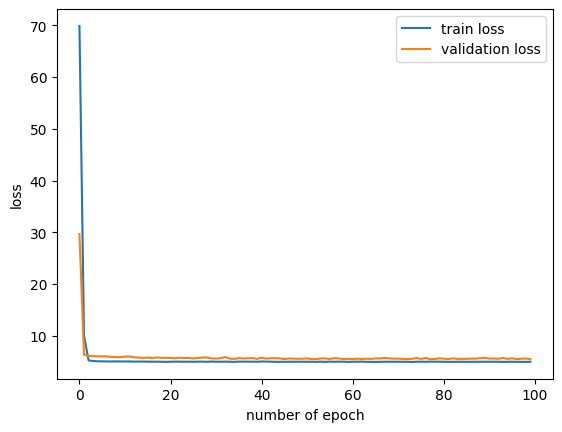

In [21]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

fitting이 아주 잘된 모범 사례처럼, **loss를 visualization한 figure은 매우 아름답다.** loss가 줄어드는 곡선의 곡률이 매우 만족스럽다. 

- 위를 확인해보니, train loss와 validation loss가 만나는 교점인 epoch 20 정도가 적당한 epoch일 것이다.

In [22]:
# train score, test score, val score

model_score = [model.evaluate(X_train_scaled, y_train), 
               model.evaluate(X_test_scaled, y_test),
             model.evaluate(X_val_scaled, y_val )]
print (f"train score, test score, val score : {model_score}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 4.9402 - mse: 4.9402
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 4.2893 - mse: 4.2893
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 5.3170 - mse: 5.3170
train score, test score, val score : [[4.930619716644287, 4.930619716644287], [4.571040630340576, 4.571040630340576], [5.476263046264648, 5.476263046264648]]


-------

### 4. DNN 
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - parameter는 최소한 500개 이상으로 증폭, 각 node의 activation은 **selu** 사용
    - epoch는 300으로 고정
- 아래와 같이 experiment할 예정이다.
    - optimizer는 **적응형 학습율 optimizer인 adam을 사용한다.**
    - validation loss 감소를 위하여 **dropout 층을 추가한다.**
        - callback으로 early stopping을 도입하지 않고, 충분히 학습하여 loss의 추이를 확인한다.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,001 (23.44 KB)

 Trainable params: 5,713 (22.32 KB)

 Non-trainable params: 288 (1.12 KB)

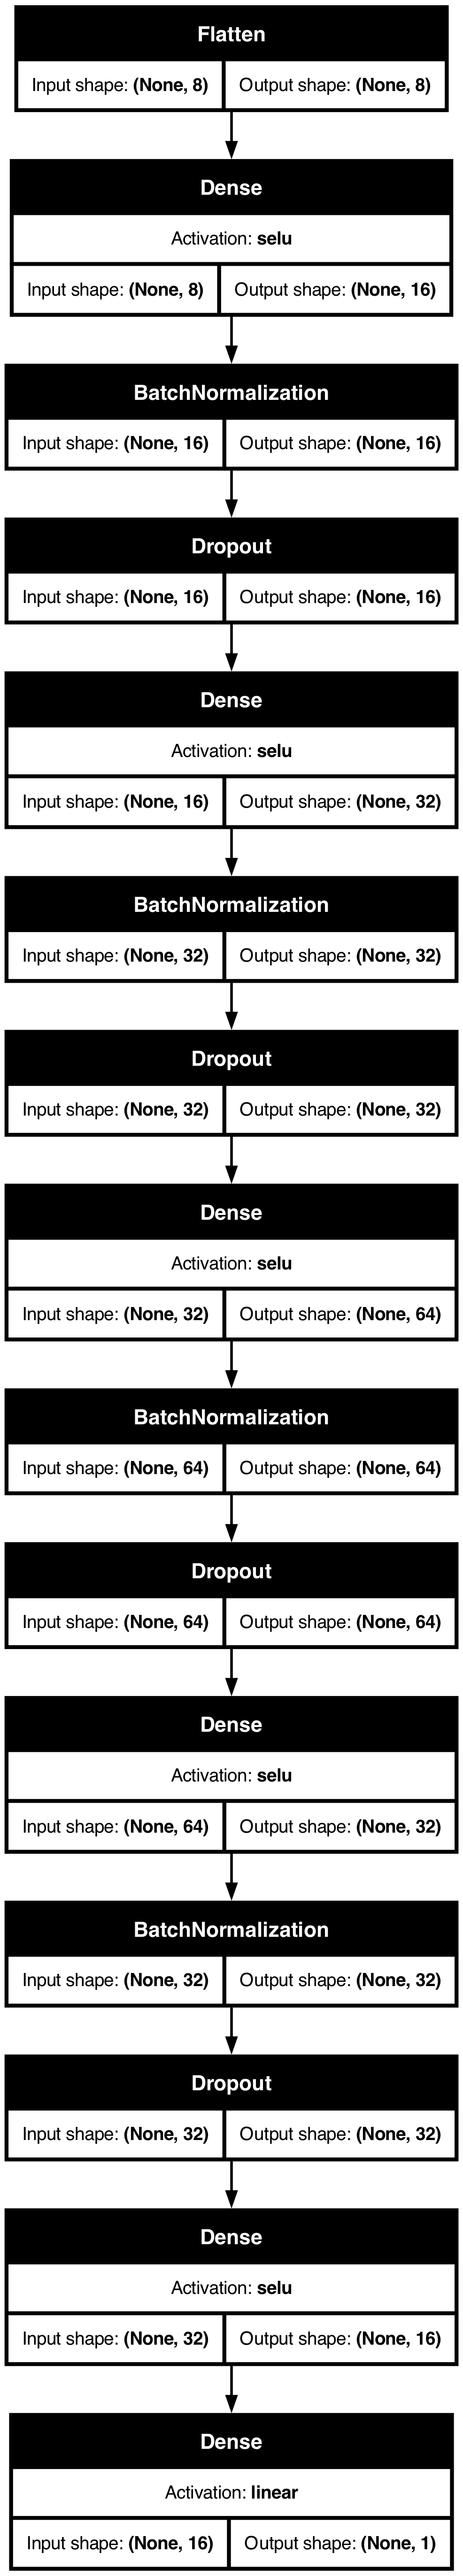

In [29]:
# modelling DNN

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len([feature for feature in df.columns if feature != 'Rings']), )), 
    keras.layers.Dense(16, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='selu'),
    keras.layers.Dense(1)
])

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [30]:
# compile

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, 
              loss='mse', metrics=['mse'])

In [31]:
# callback 설정 및 fit

# early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
#                                                  restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=300, 
                    validation_data=(X_val_scaled, y_val), 
                    # callbacks=early_stopping_cb,
                    verbose=0)

print (history.history)

{'loss': [81.68062591552734, 26.585315704345703, 10.748550415039062, 9.446773529052734, 8.95615005493164, 8.49180793762207, 8.247794151306152, 8.114453315734863, 8.137227058410645, 7.481092929840088, 7.8167266845703125, 7.522941589355469, 7.147837162017822, 6.828636646270752, 6.929907321929932, 6.82883358001709, 6.812302112579346, 6.4503583908081055, 6.385177135467529, 6.5827956199646, 6.593936443328857, 6.311428070068359, 6.528017520904541, 6.277760982513428, 6.139286518096924, 6.0427117347717285, 6.154430866241455, 6.011582374572754, 5.8971638679504395, 5.924191474914551, 6.071124076843262, 5.846062183380127, 5.688973903656006, 5.900969505310059, 5.783351421356201, 5.966399669647217, 5.547247886657715, 5.595758438110352, 5.639510631561279, 5.643295764923096, 5.75082540512085, 5.555438041687012, 5.443746566772461, 5.4588704109191895, 5.536785125732422, 5.591654300689697, 5.481001853942871, 5.701615810394287, 5.4113688468933105, 5.439812183380127, 5.538294792175293, 5.332305431365967, 

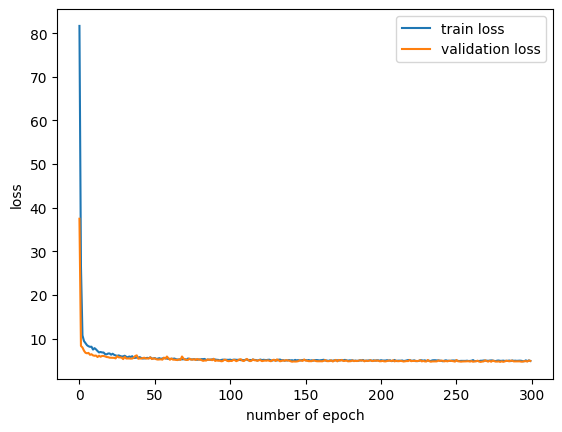

In [32]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [33]:
# train score, test score, val score

model_score = [model.evaluate(X_train_scaled, y_train), 
               model.evaluate(X_test_scaled, y_test),
             model.evaluate(X_val_scaled, y_val )]
print (f"train score, test score, val score : {model_score}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2739 - mse: 4.2739
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 3.4527 - mse: 3.4527
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 5.0284 - mse: 5.0284
train score, test score, val score : [[4.444357395172119, 4.444357395172119], [3.54642391204834, 3.54642391204834], [4.884626388549805, 4.884626388549805]]
